In [1]:
import tensorflow as tf
import cv2 as cv
import numpy as np
import os
from os.path import join
import matplotlib.pyplot as plt
from functions import analyse
from datetime import datetime as dt

In [2]:
def frame_stamp():
    current = dt.now()
    out_str = (str(current.year) + str(current.month) + str(current.day) + "_" + 
               str(current.hour) + str(current.minute) + str(current.second) + "_" +
               str(current.microsecond))
    return out_str

def load_labels():
    fdir = "labels"
    dataset = []
    x = 0
    none_count = 0
    for file in os.listdir(fdir):
        if file.endswith(".jpg"):
            img = cv.imread(os.path.join(fdir,file), cv.IMREAD_UNCHANGED)
            if not img is None:
                img = pad(img)
                if int(file[0]) == 0:    
                    dataset.append([img,np.array([0,1])])
                else:
                    dataset.append([img,np.array([1,0])])
            else:
                none_count += 1
            x += 1
    print("None count: ", none_count)
    return np.array(dataset)

def pad(arr):
    r = np.zeros((24,24,3))
    r[:arr.shape[0],:arr.shape[1],:arr.shape[2]] = arr
    return r

def split_arr(arr, percent):
    position = int(len(arr) * (1-percent))
    train_data = arr[:position]
    test_data = arr[position:]
    return train_data, test_data

In [3]:
data = load_labels()
np.random.shuffle(data)

train_data, test_data = split_arr(data, 0.25)
print("Traing_data count: ", len(train_data))
print("Test_data count: ", len(test_data))

n_classes = 2
hm_epochs = 25

x = tf.placeholder('float',[24,24,3])
y = tf.placeholder('float')

keep_rate = 0.8
keep_prob = tf.placeholder(tf.float32)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1,1,1,1], padding='SAME')

def maxpool2d(x):
    #                          size of window    moment of window
    return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1],padding='SAME')

None count:  14
Traing_data count:  1847
Test_data count:  616


In [4]:
def cnn_model(x):
    # 5 x 5, 1 input, produces 32 features
    weights = {'W_conv1':tf.Variable(tf.random_normal([5,5,3,32])),
               'W_conv2':tf.Variable(tf.random_normal([5,5,32,64])),
               'W_fc':tf.Variable(tf.random_normal([6*6*64, 1024])),
               'out':tf.Variable(tf.random_normal([1024, n_classes]))}
    
    biases = {'b_conv1':tf.Variable(tf.random_normal([32])),
              'b_conv2':tf.Variable(tf.random_normal([64])),
              'b_fc':tf.Variable(tf.random_normal([1024])),
              'out':tf.Variable(tf.random_normal([n_classes]))}
    
    x = tf.reshape(x, shape=[-1,24,24,3])
    
    conv1 = tf.nn.relu(conv2d(x, weights['W_conv1']) + biases['b_conv1'])
    conv1 = maxpool2d(conv1)
    
    conv2 = tf.nn.relu(conv2d(conv1, weights['W_conv2']) + biases['b_conv2'])
    conv2 = maxpool2d(conv2)
    
    fc = tf.reshape(conv2,[-1,6*6*64])
    fc = tf.nn.relu(tf.matmul(fc, weights['W_fc']) + biases['b_fc'])
    
    fc = tf.nn.dropout(fc,keep_rate)
    
    output = tf.matmul(fc, weights['out']) + biases['out']
    
    return output

In [5]:
def cnn_train(x, train_data, test_data, zero_catch=0, time_stamp = False):    
    prediction = cnn_model(x)
    cost = tf.reduce_mean( tf.nn.softmax_cross_entropy_with_logits(logits=prediction, labels=y) )
    optimizer = tf.train.AdamOptimizer().minimize(cost)
    saver = tf.train.Saver()
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        loss_plot = []
        hm_zeros = 0
        for epoch in range(hm_epochs):
            epoch_loss = 0
            
            for i in range(len(train_data)):
                batch_x = train_data[i][0]
                batch_y = train_data[i][1]
                _, c = sess.run([optimizer, cost], feed_dict = {x: batch_x, y: batch_y})
                epoch_loss += c
            loss_plot.append(epoch_loss)
            print('Epoch: ', epoch, ' completed out of: ', hm_epochs, ' loss: ', epoch_loss)
            if (zero_catch > 0) and (epoch_loss == 0):
                hm_zeros += 1
                if hm_zeros == zero_catch:
                    print("Reached zero catch of: ", zero_catch)
                    break
            elif (epoch_loss != 0):
                hm_zeros = 0
                
        # Check how good model is
        correct = tf.equal (tf.argmax(prediction,-1), tf.argmax(y,-1))
        accuracy = tf.reduce_mean(tf.cast(correct,'float'))
        acc = false_pos = false_neg = true_pos = true_neg = 0
        for i in range(len(test_data)):
            curr_acc = accuracy.eval({x:test_data[i,0], y:test_data[i,1]})
            true_result =  test_data[i,1][0]
            if true_result == 1 and curr_acc == 0:
                false_neg += 1
            elif true_result == 0 and curr_acc == 0:
                false_pos += 1
            elif true_result == 1 and curr_acc == 1:
                true_pos += 1
            elif true_result == 0 and curr_acc == 1:
                true_neg += 1
            acc += curr_acc
        
        #Save model to file
        if time_stamp: save_path = saver.save(sess, "./cnn_model/current_model")
        else: save_path = saver.save(sess, "./cnn_model/current_model_" + frame_stamp())
        print("Model saved in path: %s" % save_path)
        
        print("=======================================")
        print("Accuracy: ", acc/len(test_data)*100)
        print("Tests: ", len(test_data))
        print("Positive Sample: ", true_pos + false_neg)
        print("Negative Sample: ", false_pos + true_neg)
        print("Incorrect: ", false_pos + false_neg)
        print("--------------------------------------")
        print("False Positives: ", false_pos)
        print("False Negatives: ", false_neg)
        print("True  Positives: ", true_pos)
        print("True  Negatives: ", true_neg)
        plt.plot(loss_plot)
        plt.show()

Epoch:  0  completed out of:  25  loss:  560920076.0
Epoch:  1  completed out of:  25  loss:  186277479.625
Epoch:  2  completed out of:  25  loss:  32646767.125
Epoch:  3  completed out of:  25  loss:  65496353.5
Epoch:  4  completed out of:  25  loss:  47907281.375
Epoch:  5  completed out of:  25  loss:  15606214.625
Epoch:  6  completed out of:  25  loss:  14046093.5625
Epoch:  7  completed out of:  25  loss:  0.0
Epoch:  8  completed out of:  25  loss:  0.0
Epoch:  9  completed out of:  25  loss:  18833832.875
Epoch:  10  completed out of:  25  loss:  22270355.875
Epoch:  11  completed out of:  25  loss:  0.0
Epoch:  12  completed out of:  25  loss:  0.0
Epoch:  13  completed out of:  25  loss:  0.0
Epoch:  14  completed out of:  25  loss:  0.0
Epoch:  15  completed out of:  25  loss:  0.0
Epoch:  16  completed out of:  25  loss:  0.0
Epoch:  17  completed out of:  25  loss:  0.0
Epoch:  18  completed out of:  25  loss:  0.0
Epoch:  19  completed out of:  25  loss:  15892928.0313


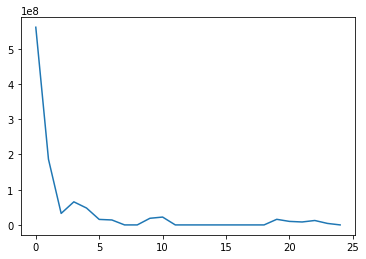

In [6]:
cnn_train(x, train_data, test_data, zero_catch=0, time_stamp=True)